# Lung Cancer Prediction - AstraZeneca Coding Challenge

## The following approach was taken to build a model to predict the survivability of a lung cancer patient after 2 years of diagnosis. 

1. Data exploration and preparation - 

Involved data cleaning and replacing missing gaps with a statistically significant value. Training without the missing data was conducted, along with replacing it with a median value for each category. Both resulted in suboptimal accuracies with several misclassirications for “deceased”. To reduce reduce the bias towards "not deceased", the mising values for the "Deceased_at_2yrs" column were imputed with random binary values rather than the mean, which improved results slgihtly. Alternative methods of imputation would be implemented next to remove bias in the dataset. Approaches like the 'MICE' and 'Random Forest Estimator' can be used to replace the missing values with a probability determined from the bayes theorem. 


2. Feature extraction - 

While the variables of the dataset remain crucial, there are 500 genes expressed for each patient and so PCA was applied to reduce dimensionality of these 500 columns. While it was determined that 194 features represent 90% of the explained variance ratio, the scree plot demonstrates that at k=10, there is a significant drop in eigenvalues, and so 10 principal components were created to represent the 500 genes' data. 


3. Unsupervised and supervisor learning models  - 

K-means clustering, logistic regression, naives bayes classified, random forrest classifier, and support vector machines. The best peformnint mode was XX as seen in figure X.


4. Deep learning model - 

Built using keras, applied an Adam optimiser, binary cross entropy loss function, to build a 3-layer neural network. It also implmeneted 'early stopping' to avoid ovefitting. It was trained for 20 epochs to demonstrate the use, however, given more time, the model will be trained for 100 epochs after adding more hidden layers for increased accuracy and precision.


5. GNN - 

Using the PPI data, a graph neural network was applied using the protein-to-protein interactions. They represent the edges of the network, and the lung cancer patient dataset was used for the nodes. Using keras, the GNN model was attempted to classify the nodes of the graph. As I have only had some exposure to GNNs, this method was learnt during the coding challenge. The full planned implementation is explained in the section below.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

In [2]:
# read the dataset and store it as a dataframe 

df = pd.read_csv('dataset.csv')
df

,Deceased_at_2yrs,Age,Sex,Smoking,Histology,Stage_simple,Gene1,Gene2,Gene3,Gene4,...,Gene523,Gene524,Gene525,Gene526,Gene527,Gene528,Gene529,Gene530,Gene531,Gene532
0,False,67.0,Male,former,LUAD,Stage 1,0.000130,0.000039,0.000255,0.000157,...,0.000255,0.000219,5.340000e-06,5.020000e-05,3.600000e-07,0.000200,1.200000e-06,0.000149,0.000439,0.000038
1,True,79.0,Female,former,LUAD,Stage 3,0.000163,0.000058,0.000422,0.000186,...,0.000117,0.000181,4.250000e-05,6.500000e-05,1.850000e-07,0.000214,4.630000e-06,0.000024,0.000230,0.000119
2,False,70.0,Male,former,LUAD,Stage 1,0.000336,0.000073,0.000317,0.000198,...,0.000075,0.000339,1.510000e-05,9.060000e-05,2.190000e-07,0.000136,1.980000e-06,0.000114,0.000254,0.000050
3,False,58.0,Female,former,LUAD,Stage 1,0.000146,0.000081,0.000186,0.000173,...,0.000102,0.000192,1.410000e-06,1.890000e-05,5.120000e-07,0.000203,8.960000e-06,0.000172,0.000173,0.000127
4,True,76.0,Male,former,LUAD,Stage 2,0.000074,0.000033,0.001240,0.000090,...,0.000016,0.000188,3.970000e-07,9.660000e-05,1.990000e-07,0.000134,7.050000e-06,0.000011,0.000145,0.000034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000126,0.000281,2.800000e-06,3.669220e-04,0.000000e+00,0.000136,5.190000e-07,0.000006,0.000288,0.000050
744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000055,0.000212,3.290000e-05,5.650000e-05,2.000000e-06,0.000233,2.060000e-05,0.000168,0.000823,0.000042
745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000123,0.000211,7.850000e-07,7.850000e-07,2.750000e-06,0.000202,9.160000e-07,0.000259,0.000455,0.000135
746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000051,0.000168,2.130000e-05,5.950000e-05,2.480000e-07,0.000197,6.690000e-06,0.000350,0.000217,0.000055


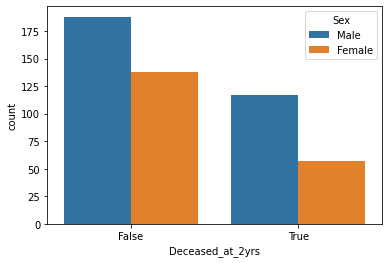

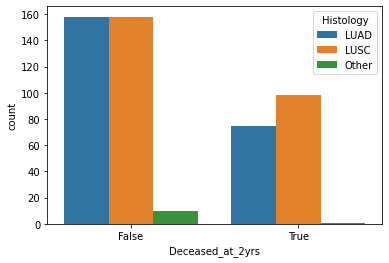

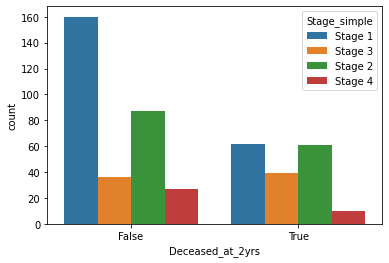

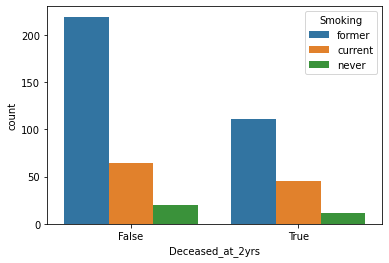

In [3]:
# visualise the data -categorical variables

plt.figure()
sns.countplot(data=df, x='Deceased_at_2yrs',hue='Sex')
plt.show()

plt.figure()
sns.countplot(data=df, x='Deceased_at_2yrs',hue='Histology')
plt.show()

plt.figure()
sns.countplot(data=df, x='Deceased_at_2yrs',hue='Stage_simple')
plt.show()

plt.figure()
sns.countplot(data=df, x='Deceased_at_2yrs',hue='Smoking')
plt.show()

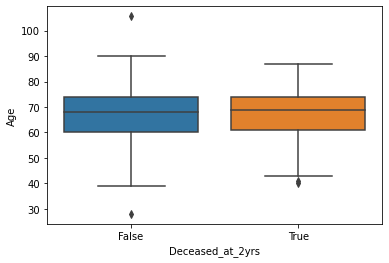

In [5]:
# visualise the data - continuous variables

plt.figure()
sns.boxplot(data=df, y='Age', x='Deceased_at_2yrs')
plt.show()

## Convert string values into binary integers 

In [6]:
df['Deceased_at_2yrs'].replace({False:0, True:1}, inplace=True)
df['Sex'].replace({'Male':0, 'Female':1}, inplace=True)
df['Smoking'].replace({'former':0, 'current':1, 'never':2}, inplace=True)
df['Histology'].replace({'LUAD':0, 'LUSC':1, 'Other':2}, inplace=True)
df['Stage_simple'].replace({'Stage 1':0, 'Stage 2':1, 'Stage 3':2,'Stage 4':3}, inplace=True)

df.head()

,Deceased_at_2yrs,Age,Sex,Smoking,Histology,Stage_simple,Gene1,Gene2,Gene3,Gene4,...,Gene523,Gene524,Gene525,Gene526,Gene527,Gene528,Gene529,Gene530,Gene531,Gene532
0,0.0,67.0,0.0,0.0,0.0,0.0,0.000130,0.000039,0.000255,0.000157,...,0.000255,0.000219,5.340000e-06,0.000050,3.600000e-07,0.000200,0.000001,0.000149,0.000439,0.000038
1,1.0,79.0,1.0,0.0,0.0,2.0,0.000163,0.000058,0.000422,0.000186,...,0.000117,0.000181,4.250000e-05,0.000065,1.850000e-07,0.000214,0.000005,0.000024,0.000230,0.000119
2,0.0,70.0,0.0,0.0,0.0,0.0,0.000336,0.000073,0.000317,0.000198,...,0.000075,0.000339,1.510000e-05,0.000091,2.190000e-07,0.000136,0.000002,0.000114,0.000254,0.000050
3,0.0,58.0,1.0,0.0,0.0,0.0,0.000146,0.000081,0.000186,0.000173,...,0.000102,0.000192,1.410000e-06,0.000019,5.120000e-07,0.000203,0.000009,0.000172,0.000173,0.000127
4,1.0,76.0,0.0,0.0,0.0,1.0,0.000074,0.000033,0.001240,0.000090,...,0.000016,0.000188,3.970000e-07,0.000097,1.990000e-07,0.000134,0.000007,0.000011,0.000145,0.000034


## Replace missing values with a statistically significant value, such as the median

In [7]:
# df = df.sample(frac=1.).reset_index(drop=True)

# check rows which contain NaN values
is_clean = df.apply(lambda x: x.isna().sum()<1,axis=1)

# get idx for rows that have no NaN values
n_clean   = len(df)
clean_idx = df.index[is_clean][:n_clean]

dfclean = df.iloc[clean_idx,:].copy().reset_index(drop=True)

mask = [x for x in df.index if x not in clean_idx]
X    = df.iloc[mask,:].copy().reset_index(drop=True)

X_fill = X.copy()

# for each column, replace missings with median

for col in X_fill.columns[1:]:
    X_fill[col] = X_fill[col].fillna(X_fill[col].median())

# the median was causing a heavy bias towards 'not deceased', affecting model performance, 
# and so the missing values for deceased_at_2rs were imputed using random values between 0 and 1
col = X_fill.columns[0]
X_fill[col] = X_fill[col].fillna(np.random.randint(0.0,1.0))

In [8]:
# final dataset with no missing values

dfclean = pd.concat([dfclean, X_fill])
dfclean.reset_index(drop=True, inplace=True)

## Feature extraction using PCA reduces dimensionality of data and selects the most relevant features


In [9]:
features = dfclean.columns[6:] # all the columns for genes 1 to 532

x = dfclean.loc[:, features].values

x = StandardScaler().fit_transform(x)   # scale the data to ensure it fits 
df_pca = pd.DataFrame(data = x, columns = features)
# df_pca.replace(np.NaN, 0,inplace=True)
df_pca

,Gene1,Gene2,Gene3,Gene4,Gene5,Gene6,Gene7,Gene8,Gene9,Gene10,...,Gene523,Gene524,Gene525,Gene526,Gene527,Gene528,Gene529,Gene530,Gene531,Gene532
0,-0.100271,-0.648363,-0.862732,-0.275220,-0.246234,0.547710,-0.195598,-0.468710,0.548874,-0.087969,...,0.511700,-0.306978,-0.329030,-0.136102,-0.347643,-0.156102,-0.359862,0.282267,-0.166637,-0.631994
1,0.116518,0.034348,-0.369070,0.290185,-0.759891,-0.653496,0.946176,-0.539083,1.284921,-0.055913,...,-0.266162,-0.513877,1.040195,0.022053,-0.415013,-0.026516,0.019687,-0.607794,-0.850218,-0.147270
2,1.255010,0.562217,-0.679827,0.526316,1.101859,-0.090196,-0.177611,-0.383566,1.459520,0.485592,...,-0.500171,0.348452,0.030594,0.295619,-0.401924,-0.742969,-0.273551,0.031006,-0.773249,-0.560278
3,0.006547,0.829671,-1.067321,0.034176,-0.691953,0.486584,-0.375700,-0.526920,-0.713549,-0.086762,...,-0.346756,-0.451529,-0.473838,-0.470579,-0.289127,-0.132948,0.498826,0.449886,-1.038343,-0.097756
4,-0.461833,-0.848954,2.055080,-1.596099,-1.078615,-0.777629,0.631956,-0.075808,0.686303,-0.083010,...,-0.830641,-0.473676,-0.511164,0.359736,-0.409623,-0.755971,0.287473,-0.698802,-1.130216,-0.652911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,-0.132260,-0.453052,-0.041877,-0.320118,-0.422501,-0.027502,-0.187064,-0.117502,-0.235174,-0.076110,...,-0.211719,0.032538,-0.422621,3.248440,-0.486232,-0.740191,-0.435219,-0.730513,-0.661672,-0.559680
744,-0.132260,-0.453052,-0.041877,-0.320118,-0.422501,-0.027502,-0.187064,-0.117502,-0.235174,-0.076110,...,-0.612576,-0.346944,0.686466,-0.068780,0.283709,0.146482,1.786858,0.420216,1.096076,-0.608089
745,-0.132260,-0.453052,-0.041877,-0.320118,-0.422501,-0.027502,-0.187064,-0.117502,-0.235174,-0.076110,...,-0.231013,-0.349193,-0.496867,-0.664159,0.572437,-0.138486,-0.391289,1.064270,-0.113788,-0.052695
746,-0.132260,-0.453052,-0.041877,-0.320118,-0.422501,-0.027502,-0.187064,-0.117502,-0.235174,-0.076110,...,-0.636181,-0.586530,0.259044,-0.036721,-0.390759,-0.180517,0.247637,1.713180,-0.893723,-0.529798


In [11]:
# PCA on entire dataest to determine what 'k' number of components represent the data well
pca = PCA()
principalComponents = pca.fit_transform(df_pca)
principalComponents.shape

(748, 532)

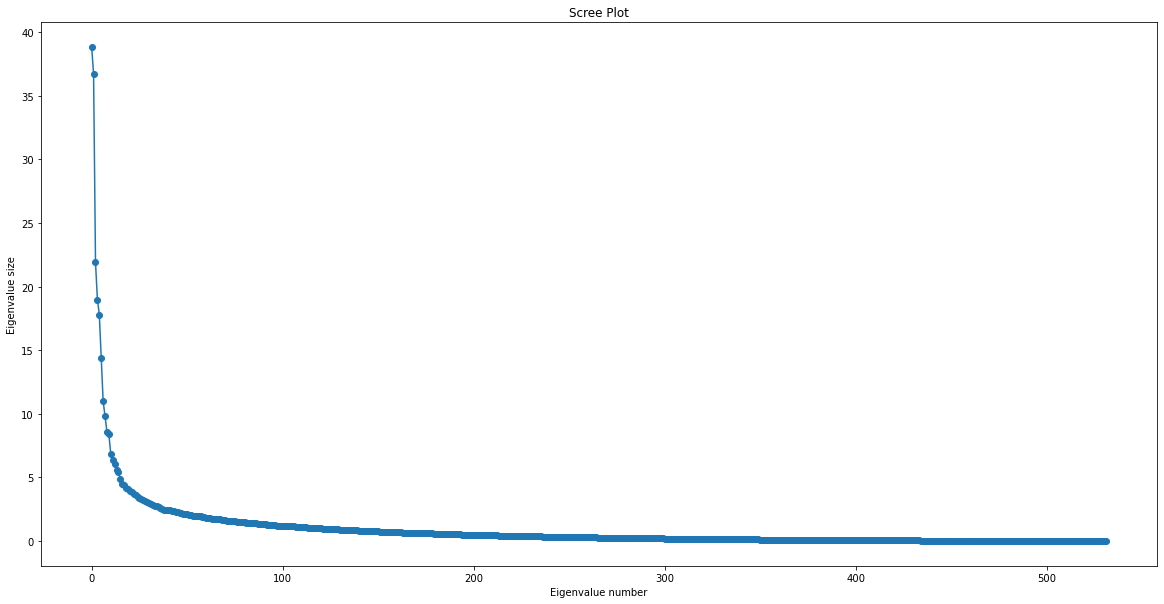

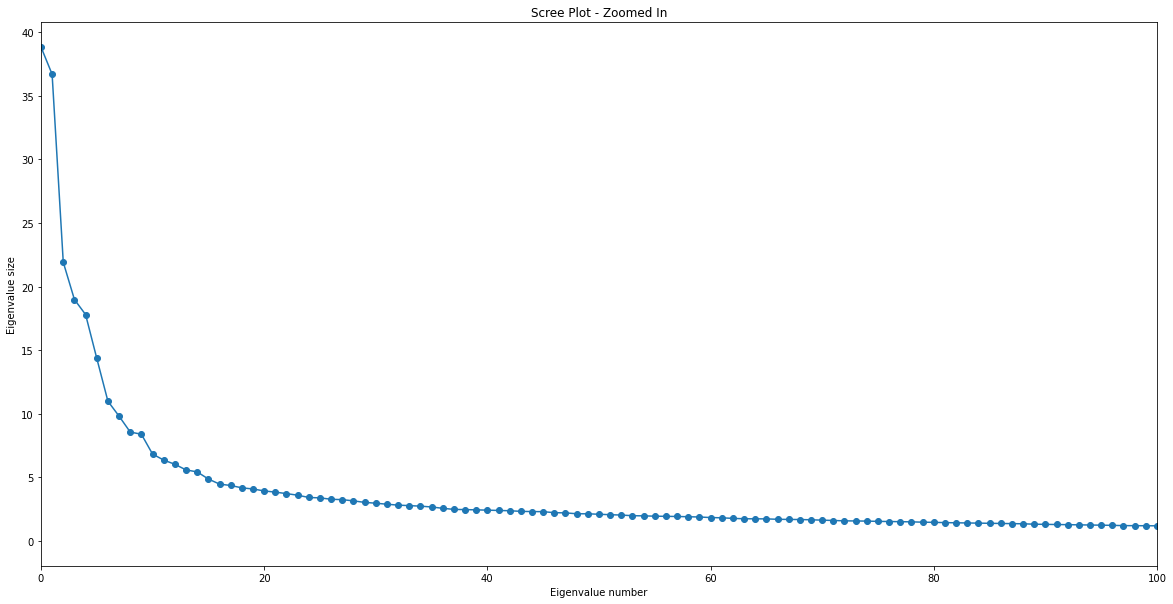

In [12]:
# scree plot - shows the elbow of the graph is at around k=10

plt.figure(figsize=(20,10))
plt.plot(pca.explained_variance_, marker='o')
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue size")
plt.title("Scree Plot")
plt.show()

plt.figure(figsize=(20,10))
plt.plot(pca.explained_variance_, marker='o')
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue size")
plt.title("Scree Plot - Zoomed In")
plt.xlim([0, 100])
plt.show()

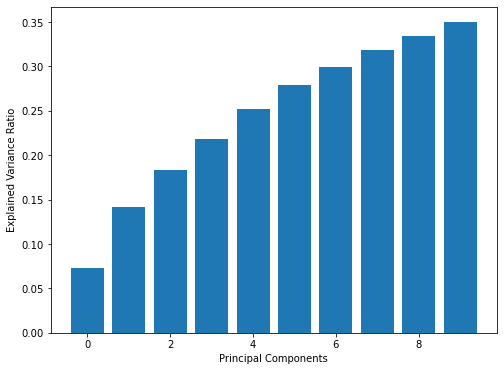

In [13]:
# k=10 was used, the explained variance ratio (cumulative) for k = 1 
# to 10 is given below to observe how much of the variance is represented by 10 components
# in an ideal situation, a k-value that captures 90% of the variance is ideal, however this value is at 194, 
# which is too large

k = 10
pca = PCA(n_components=k)
df_pca.pca = pca.fit(df_pca)
X_pca = pca.transform(df_pca)

var_exp = (pca.explained_variance_ratio_.cumsum())
plt.figure(figsize=(8,6))
plt.bar(range(k), var_exp)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [14]:
principalDf = pd.DataFrame(data = X_pca, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 
                                                    'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])

In [15]:
# dfclean[dfclean.columns[0:6]]
principalDf.reset_index(drop=True, inplace=True)

In [16]:
# final dataframe - prepared for ML
finalDf = pd.concat([dfclean[dfclean.columns[0:6]], principalDf],axis=1)
finalDf.head(5)

,Deceased_at_2yrs,Age,Sex,Smoking,Histology,Stage_simple,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,0.0,67.0,0.0,0.0,0.0,0.0,-4.171098,-5.525806,2.001378,1.113228,-1.914600,-1.806062,0.653284,-0.516435,-3.013149,0.097562
1,1.0,79.0,1.0,0.0,0.0,2.0,-1.414481,1.163308,-6.092066,-0.340593,-3.927819,0.927215,-0.192524,3.773366,3.128208,-0.799131
2,0.0,70.0,0.0,0.0,0.0,0.0,-1.322294,-0.290794,-1.125144,-1.122324,-6.583270,7.039615,1.750851,1.890475,-3.641818,-4.088721
3,0.0,58.0,1.0,0.0,0.0,0.0,-1.118938,0.724557,1.426758,0.661264,-5.364612,-2.113609,4.703549,1.480081,-1.328752,-0.075600
4,1.0,76.0,0.0,0.0,0.0,1.0,-1.532029,3.662154,-6.299965,-1.803696,-9.798336,2.347439,-1.463270,2.850003,5.669169,-2.528487


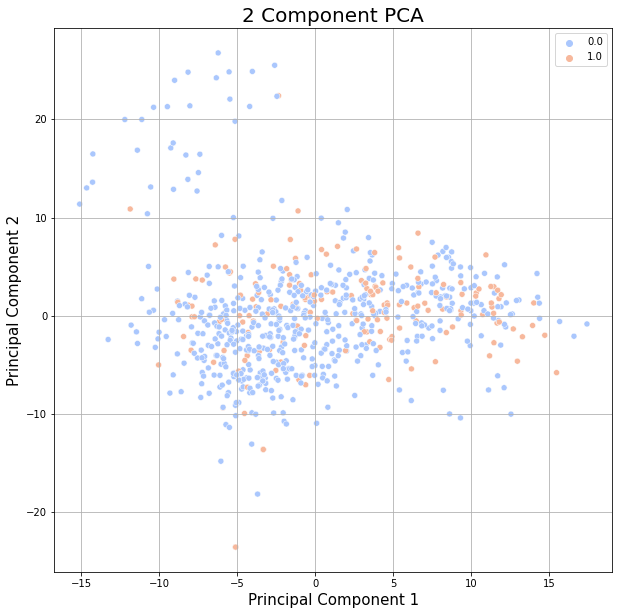

In [17]:
# visulaising the variance captured by the first two PCs - 
# can see that the 'not deceased' and 'deceased' values are not very separable

# LDA should demonstrate its separability, which can be applied taking 2-3 columns in the sklearn.lda.LDA() function. 

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

sns.scatterplot(data=finalDf, x='PC1', y='PC2', hue='Deceased_at_2yrs',palette='coolwarm')
ax.legend()
ax.grid()

## Splitting data into train and test and running the following models 

1. K-Means Clustering
2. Logistic Regression
3. Random Forest Classifier
4. Naive Bayes Classifer
5. Support Vector Machine

In [18]:
# input vs output 

X=finalDf[['Age', 'Sex', 'Smoking', 'Histology','Stage_simple',
           'PC1', 'PC2', 'PC3', 'PC4','PC5',
           'PC6', 'PC7', 'PC8', 'PC9', 'PC10']]
y=finalDf['Deceased_at_2yrs']

In [19]:
# split into train and test data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

K-means accuracy: 0.662


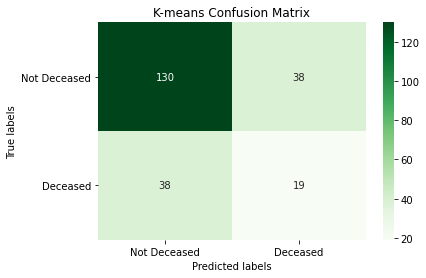

In [46]:
### K MEANS CLUSTERING

kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train)
km_pred = kmeans.predict(X_test)
kmeansacc = round(accuracy_score(y_test, km_pred),3)

print('K-means accuracy:', kmeansacc)

cm_km = confusion_matrix(y_test, km_pred)

ax = plt.subplot()
sns.heatmap(cm_km, annot=True, ax = ax, fmt='g', cmap='Greens') 
labels = ['Not Deceased', 'Deceased']
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('K-means Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

Naive Bayes accuracy: 0.689


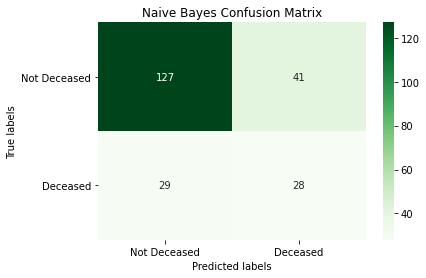

In [47]:
### Niave bayes (gaussian) classifier

nb_model = GaussianNB()

nb_model.fit(X_train, y_train)

nb_pred = nb_model.predict(X_test)
nbacc = round(accuracy_score(y_test, nb_pred), 3)
print('Naive Bayes accuracy:', nbacc)

cm_nb =  confusion_matrix(y_test, nb_pred)

ax = plt.subplot()
sns.heatmap(cm_nb, annot=True, ax = ax, fmt='g', cmap='Greens') 
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Naive Bayes Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);


Best Parameters:
 {'C': 0.001, 'penalty': 'l1'}
Logistic Regression accuracy: 0.747


[Text(0, 0.5, 'Not Deceased'), Text(0, 1.5, 'Deceased')]

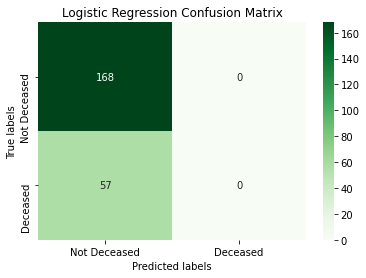

In [48]:
### logistic regression 
# the gridsearchCV is an exhaustive search technique to determine the best parameters for this task

log_grid = {'C': [1e-03, 1e-2, 1e-1,1,10], 
                 'penalty': ['l1', 'l2']}     # for regularisation, removes unwanted features by penalising their errors

log_estimator = LogisticRegression(solver='liblinear')

log_model = GridSearchCV(estimator=log_estimator, 
                  param_grid=log_grid, 
                  cv=3,                        # cross validation k fold = 3
                  scoring='accuracy')

log_model.fit(X_train, y_train)

print("Best Parameters:\n", log_model.best_params_)

# Select best log model
best_log = log_model.best_estimator_

# Make predictions using the optimised parameters
log_pred = best_log.predict(X_test)

logacc = round(accuracy_score(y_test, log_pred), 3)
print('Logistic Regression accuracy:', logacc)

cm_log =  confusion_matrix(y_test, log_pred)

ax = plt.subplot()
sns.heatmap(cm_log, annot=True, ax = ax, fmt='g', cmap='Greens') 
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Logistic Regression Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)

Best Parameters:
 {'bootstrap': False, 'max_features': 0.6, 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 100}
Random Forest accuracy: 0.756


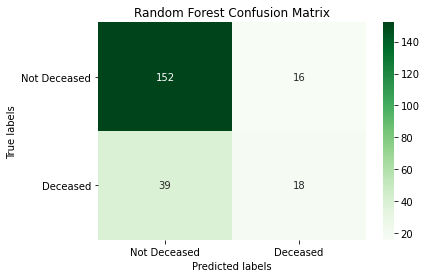

In [36]:
### Random forest classifier

# Hyperparameters search grid 
rf_param_grid = {'bootstrap': [False, True],
         'n_estimators': [60, 70, 80, 90, 100],
         'max_features': [0.6, 0.65, 0.7, 0.75, 0.8],
         'min_samples_leaf': [8, 10, 12, 14],
         'min_samples_split': [3, 5, 7]
        }

rf_estimator = RandomForestClassifier(random_state=0)

# GridSearchCV with cv k-fold = 3
rf_model = GridSearchCV(estimator=rf_estimator, param_grid=rf_param_grid, cv=3, scoring='accuracy')

# fit model for the best hyperparameters
rf_model.fit(X_train, y_train)

print("Best Parameters:\n", rf_model.best_params_)

#  best model
rf_model_best = rf_model.best_estimator_

# predict using the optimised parameters
rf_pred = rf_model_best.predict(X_test)

rfacc = round(accuracy_score(y_test, rf_pred), 3)
print('Random Forest accuracy:', rfacc)

cm_rf = confusion_matrix(y_test, rf_pred)

ax = plt.subplot()
sns.heatmap(cm_rf, annot=True, ax = ax, fmt='g', cmap='Greens') 
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Random Forest Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

SVM accuracy: 0.747


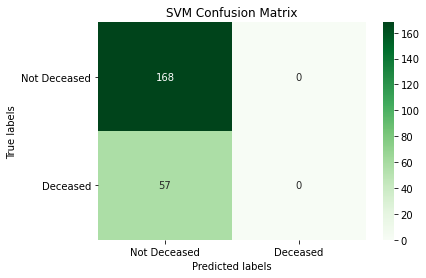

In [49]:
### SVM

# # Parameter grid
# svm_param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10], 
#                   "kernel": ["linear", "rbf", "poly"], 
#                   "decision_function_shape" : ["ovo", "ovr"]} 

# # Create SVM grid search classifier
# svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=3)

# # Train the classifier
# svm_grid.fit(X_train, y_train)

# print("Best Parameters:\n", svm_grid.best_params_)

# # Select best svc
# best_svc = svm_grid.best_estimator_

# # Make predictions using the optimised parameters
# svm_pred = best_svc.predict(X_test)

svc = SVC()
svc = svc.fit(X_train,y_train)
svc_pred = svc.predict(X_test)

svcacc=  round(accuracy_score(y_test, svc_pred), 3)
print('SVM accuracy:', svcacc)

cm_svm =  confusion_matrix(y_test, svc_pred)

ax = plt.subplot()
sns.heatmap(cm_svm, annot=True, ax = ax, fmt='g', cmap='Greens') 

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('SVM Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

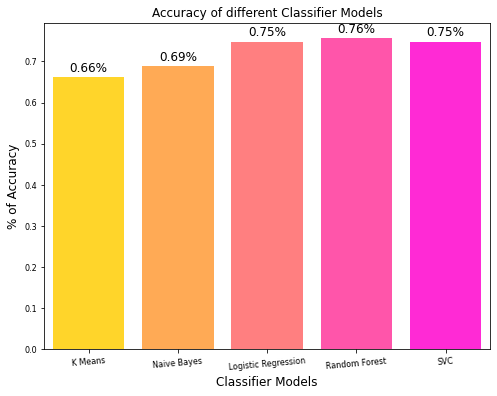

In [51]:
## comparing the mchine learning methods by visualising their accuracy 
rfacc=round(accuracy_score(y_test, rf_pred), 3)
model_list = ['K Means', 'Naive Bayes', 'Logistic Regression','Random Forest','SVC']
accuracy_list=[kmeansacc,nbacc, logacc, rfacc, svcacc]

plt.figure(figsize=(8,6))
ax = sns.barplot(x=model_list, y=accuracy_list, palette = "spring_r", saturation =2.0)
plt.xlabel('Classifier Models', fontsize = 12)
plt.ylabel('% of Accuracy', fontsize = 12)
plt.title('Accuracy of different Classifier Models', fontsize = 12)
plt.xticks(fontsize = 8, horizontalalignment = 'center', rotation = 5)
plt.yticks(fontsize = 8)

for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    ax.annotate(f'{round(height,2)}%', (x + width/2, y + height*1.02), ha='center', fontsize = 'large')
plt.show()

- The best classifier is random forest, followed by SVC and logistic regression. 
- The supervised based methods perform better than the ubsupervised based methods. 
- This could be because it can automatically balance data sets when a class is more infrequent than other classes in the data, which is the case with the current dataset (not deceased>> deceased).

## Deep Learning Approach - building a simple model 

- Using Keras 
- Adam Optimiser
- Binary Cross-Entropy Loss Function

In [52]:
# Create training and validation data

X_train_2 = X_train[:400]
X_val = X_train[400:]

y_train_2 = y_train[:400]
y_val = y_train[400:]

In [53]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(15,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer='adam',
loss='binary_crossentropy',
metrics=['accuracy'])

# Set up early stopping
es = EarlyStopping(monitor='val_loss', verbose=1, patience=3)

# Fit model
history = model.fit(X_train_2, y_train_2, 
                    epochs=20,
                    batch_size=4,
                    validation_data=(X_val, y_val),
                    callbacks=[es])

Epoch 1/20
100/100 [==============================] - 1s 5ms/step - loss: 0.7805 - accuracy: 0.7100 - val_loss: 0.6224 - val_accuracy: 0.7317
Epoch 2/20
100/100 [==============================] - 0s 4ms/step - loss: 0.5490 - accuracy: 0.7700 - val_loss: 0.5565 - val_accuracy: 0.7480
Epoch 3/20
100/100 [==============================] - 0s 3ms/step - loss: 0.5292 - accuracy: 0.7775 - val_loss: 0.5359 - val_accuracy: 0.7561
Epoch 4/20
100/100 [==============================] - 0s 3ms/step - loss: 0.4970 - accuracy: 0.7850 - val_loss: 0.5353 - val_accuracy: 0.7398
Epoch 5/20
100/100 [==============================] - 0s 3ms/step - loss: 0.4878 - accuracy: 0.7800 - val_loss: 0.5106 - val_accuracy: 0.7398
Epoch 6/20
100/100 [==============================] - 0s 4ms/step - loss: 0.4709 - accuracy: 0.7850 - val_loss: 0.5286 - val_accuracy: 0.7480
Epoch 7/20
100/100 [==============================] - 0s 3ms/step - loss: 0.4929 - accuracy: 0.7775 - val_loss: 0.5416 - val_accuracy: 0.7398
Epoch 

In [58]:
# get accuracy of model training

_, accuracy = model.evaluate(X_test, y_test)
print('Training Accuracy: %.2f' % (accuracy*100), '%')

8/8 [==============================] - 0s 2ms/step - loss: 0.5458 - accuracy: 0.7733
Training Accuracy: 77.33 %


In [59]:
# Make predictions
nn_pred = model.predict(X_test)
nn_pred_class=np.argmax(nn_pred, axis=1)
nn_pred_class

## this shows all classes are classified as 'not deceased' - the imbalnace in the dataset causes this

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

Neural Network accuracy:  74.7 %


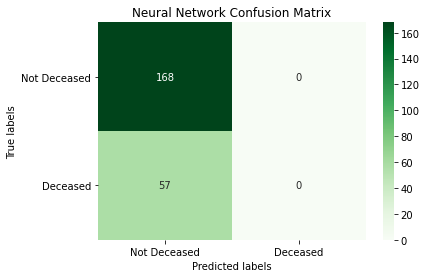

In [60]:
print('Neural Network accuracy: ', round(accuracy_score(y_test, nn_pred_class), 3)*100, '%')

cm_nn = confusion_matrix(y_test, nn_pred_class)

ax = plt.subplot()
sns.heatmap(cm_nn, annot=True, ax = ax, fmt='g', cmap='Greens') 

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Neural Network Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

## Building a Graph Neural Network with the PPI dataset

In [61]:
df1 = pd.read_csv('ppi_data.csv')
df1.drop('Unnamed: 0', inplace=True, axis=1)
df1.head()

,source_gene,target_gene
0,Gene301,Gene17
1,Gene110,Gene103
2,Gene108,Gene292
3,Gene495,Gene292
4,Gene222,Gene274


In [62]:
df1.describe()

,source_gene,target_gene
count,2500,2500
unique,531,526
top,Gene93,Gene44
freq,12,15


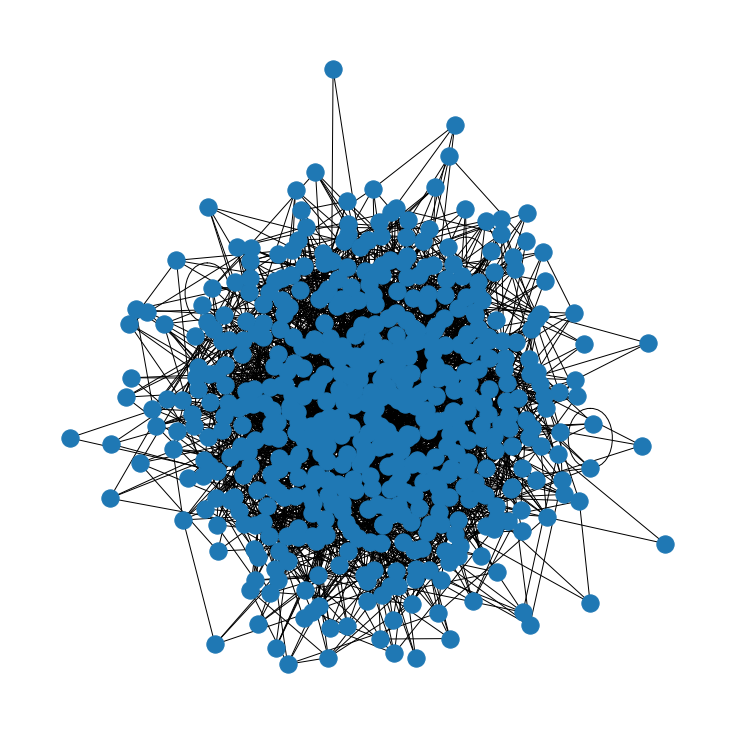

In [63]:
import networkx as nx
import matplotlib.pyplot as plt

# visualising the graph

plt.figure(figsize=(10, 10))
g = nx.from_pandas_edgelist(df1, source='source_gene', target='target_gene') 
nx.draw(g)
plt.show()


In [66]:
# class values
class_values = sorted(finalDf["Deceased_at_2yrs"].unique())
class_idx = {name: idx for idx, name in enumerate(class_values)}

In [67]:
# the following method was learnt and implemented from https://keras.io/examples/graph/gnn_citations/
import tensorflow as tf

feature_names = set(finalDf.columns) - {"Deceased_at_2yrs"}
feature_names

{'Age',
 'Histology',
 'PC1',
 'PC10',
 'PC2',
 'PC3',
 'PC4',
 'PC5',
 'PC6',
 'PC7',
 'PC8',
 'PC9',
 'Sex',
 'Smoking',
 'Stage_simple'}

In [68]:
# edges
edges = df1[["source_gene", "target_gene"]].to_numpy().T
print("Edges shape:", edges.shape)

Edges shape: (2, 2500)


In [69]:
node_features = tf.cast(
    finalDf.sort_values("Deceased_at_2yrs")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
print("Nodes shape:", node_features.shape)

Nodes shape: (748, 15)


In [70]:
edge_weights = tf.ones(shape=edges.shape[1])
print("Edges_weights shape:", edge_weights.shape)

Edges_weights shape: (2500,)


In [71]:
graph_info = (node_features, edges, edge_weights)

In [77]:
#split the data into training and testing

x_train = finalDf[finalDf.columns].to_numpy()
y_train = finalDf["Deceased_at_2yrs"]

Due to the time limit and learning curve, the GNN model was not successfully implemented. From my understanding, the following approach should allow the final classification.

- we have two models, a GNN, and a NN
- the GNN is built on the class given below, along with the integration of a feed-forward network, and a baseline neural network. The total parameters should be similar to the GNN model.
- Running the model should create the connected graph, along with the class probabilities for each node. 

In [84]:

class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [83]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=2,
    hidden_units=[32,32],
    dropout_rate=0.5,
    name="gnn_model",
)
gnn_model.summary()

NameError: name 'create_ffn' is not defined

In [85]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(0.01),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [ ]:
## plot accuracy from model training 

history = run_experiment(gnn_model, x_train, y_train)
 
fig, ax2 = plt.subplots(1, figsize=(15, 5))
ax2.plot(history.history["acc"])
ax2.plot(history.history["val_acc"])
ax2.legend(["train", "test"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()